# Summary: Evaluate Real HAR Data on Dataset 6 Model
This notebook evaluates real-world Android sensor data against a model trained on Human Activity Recognition (HAR) Dataset 6 (50Hz sampling rate). It focuses on data alignment and performance analysis. Key tasks:
- Load Dataset 6 using a custom `dataloading` module.
- Read real sensor data (accelerometer, gravity, gyroscope) from CSV files collected via [Sensor Logger](https://github.com/tszheichoi/awesome-sensor-logger).
- Align real data with Dataset 6’s format, addressing iOS-to-Android coordinate mapping issues.
- Visualize real data vs. Dataset 6 samples to identify discrepancies (e.g., attitude.roll, pitch, yaw).
- Evaluate model performance, noting low accuracy (12% for sitting, 1% for walking) due to data mismatches.
- Suggest improvements: correct iOS-to-Android mappings, trim boundary data, and test with Android-based datasets.
The goal is to assess the model’s generalization on real Android HAR data and identify alignment challenges.

In [1]:
import sys
import dataloading
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

### Load Data 6
sampling_rate = 50Hz

In [2]:
df = dataloading.load_data6()

[['attitude.roll', 'attitude.pitch', 'attitude.yaw'], ['gravity.x', 'gravity.y', 'gravity.z'], ['rotationRate.x', 'rotationRate.y', 'rotationRate.z'], ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']]
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series


In [3]:
df.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,activity,subject
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,downstairs,0.0
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,downstairs,0.0
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,downstairs,0.0
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,downstairs,0.0
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,downstairs,0.0


In [4]:
df = df.drop(columns=['subject'])
print(df.shape)
df.head()

(1412865, 13)


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,activity
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,downstairs
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,downstairs
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,downstairs
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,downstairs
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,downstairs


In [5]:
X_train,y_train,X_test,y_test,labels = dataloading.train_test_split(df,test_size=0.2)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (1130292, 12), y_train: (1130292,), X_test: (282573, 12), y_test: (282573,)


### Pass sensor data to test dataset

In [6]:
def read_android_logger_sensor_data(path_to_sensor_data):
    filename = "/Accelerometer.csv"
    acc_df = pd.read_csv(path_to_sensor_data + filename)

    filename = "/gravity.csv"
    gravity_df = pd.read_csv(path_to_sensor_data + filename)

    filename = "/Gyroscope.csv"
    rot_rate_df = pd.read_csv(path_to_sensor_data + filename)

    filename = "/Orientation.csv"
    orientation_df = pd.read_csv(path_to_sensor_data + filename)
    
    return (acc_df, gravity_df, rot_rate_df, orientation_df)

In [7]:
def to_data6_df(acc_df, gravity_df, rot_rate_df, orientation_df):
    acc_df_ios_coord = acc_df.copy()
    acc_df_ios_coord = acc_df / 9.81
    acc_df_ios_coord['z'] = -acc_df_ios_coord['z']
    
    orientation_df_ios_coord = orientation_df.copy()
    orientation_df_ios_coord['roll'] = -orientation_df_ios_coord['roll']
#     orientation_df_ios_coord['pitch'] = -orientation_df_ios_coord['pitch']
#     orientation_df_ios_coord['yaw'] = -orientation_df_ios_coord['yaw']
    dfs = [orientation_df_ios_coord[['roll', 'pitch', 'yaw']], gravity_df[['x', 'y', 'z']], rot_rate_df[['x', 'y', 'z']], acc_df_ios_coord[['x', 'y', 'z']]]

    # Find the minimum number of samples
    min_samples = min(len(df) for df in dfs)

    # add an empty cosine column till we find what this thing is
    #cos_df = pd.DataFrame({'cos': [0] * min_samples})

    # Trim each DataFrame to the minimum length
    balanced_df_list = [df.iloc[:min_samples] for df in dfs] #+ [cos_df]
    balanced_df = pd.concat(balanced_df_list, axis = 1)
    
    return balanced_df

#### Test walking

In [13]:
filename = "2025-02-12_19-52-05"
data_path = "/Users/admin/Desktop/" + filename

acc_df, gravity_df, rot_rate_df, orientation_df = read_android_logger_sensor_data(data_path)
balanced_df = to_data6_df(acc_df, gravity_df, rot_rate_df, orientation_df)
raw_data = balanced_df.to_numpy()
# take rolling avg
window_size = 3
rolling_avg_data = np.copy(raw_data) # np.apply_along_axis(lambda m: np.convolve(m, np.ones(window_size)/window_size, mode='valid'), axis=0, arr=raw_data)
print(raw_data.shape)
print(rolling_avg_data.shape)
real_labels = np.full((rolling_avg_data.shape[0]), 'walking')
test_df = pd.concat([pd.DataFrame(rolling_avg_data), pd.DataFrame({'activity':real_labels})], axis=1)

(381, 12)
(381, 12)


In [14]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,activity
0,0.556491,0.002545,2.550992,2.679417,-0.672009,9.409543,0.796817,-1.971004,0.448343,-0.015021,0.081913,0.066778,walking
1,1.038140,0.047555,2.298527,4.001181,-0.150977,8.951991,1.400023,-4.230961,1.456748,-0.136865,0.051011,0.155181,walking
2,1.253736,0.331178,2.107325,7.029403,0.112872,6.837042,2.496978,-6.544580,2.744119,-0.518712,-0.399437,0.138241,walking
3,1.356783,0.585617,1.734980,8.802006,-1.746389,3.955404,0.565389,-3.452653,3.539871,-0.152825,-0.523066,0.194333,walking
4,1.308213,0.517267,1.594367,8.422594,-4.581969,2.058120,1.588841,-3.579818,4.492350,0.579545,-0.433266,-0.839429,walking


In [15]:
X_train_real, y_train_real, X_test_real, y_test_real,labels = dataloading.train_test_split(test_df,test_size=0.99, scaler_type="standard")
print(f"X_train: {X_train_real.shape}, y_train: {y_train_real.shape}, X_test: {X_test_real.shape}, y_test: {y_test_real.shape}")
client_data = dataloading.to_client(data=(X_train,y_train,X_test_real,y_test_real),max_clients=1)
dataloading.save_client_data(client_data,"dataset_6_real_experiment_2")

X_train: (3, 12), y_train: (3,), X_test: (378, 12), y_test: (378,)


#### Test sitting

In [8]:
filename = "2025-02-12_21-47-00"
data_path = "/Users/admin/Desktop/" + filename

acc_df, gravity_df, rot_rate_df, orientation_df = read_android_logger_sensor_data(data_path)
balanced_df = to_data6_df(acc_df, gravity_df, rot_rate_df, orientation_df)
raw_data = balanced_df.to_numpy()
# take rolling avg
window_size = 3
rolling_avg_data = np.copy(raw_data) # np.apply_along_axis(lambda m: np.convolve(m, np.ones(window_size)/window_size, mode='valid'), axis=0, arr=raw_data)
print(raw_data.shape)
print(rolling_avg_data.shape)

lable_type = 'sitting'
real_labels = np.full((rolling_avg_data.shape[0]), lable_type)
test_df = pd.concat([pd.DataFrame(rolling_avg_data), pd.DataFrame({'activity':real_labels})], axis=1)

(394, 12)
(394, 12)


In [9]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,activity
0,0.968514,0.446626,1.225090,7.202235,-4.529876,4.876314,-0.670051,0.123437,0.647014,-0.006574,0.048113,0.035926,sitting
1,0.931645,0.665430,1.250931,6.778457,-5.245382,4.765383,-0.473110,0.321044,0.560329,0.025426,0.045524,0.008136,sitting
2,0.969669,0.735061,1.263948,6.366938,-5.778982,4.715490,-0.437158,0.153132,0.681103,0.004466,0.092044,-0.004898,sitting
3,1.176252,0.855348,1.344854,6.035187,-6.338155,4.424329,-0.579237,-0.066712,0.767123,-0.066769,0.201236,-0.046468,sitting
4,1.379252,1.184450,1.507378,6.134382,-6.840895,3.426646,-0.708667,-0.510528,0.561660,-0.557114,0.174735,0.081541,sitting


In [10]:
X_train_real, y_train_real, X_test_real, y_test_real,labels = dataloading.train_test_split(test_df,test_size=0.99, scaler_type="standard")
print(f"X_train: {X_train_real.shape}, y_train: {y_train_real.shape}, X_test: {X_test_real.shape}, y_test: {y_test_real.shape}")

client_data = dataloading.to_client(data=(X_train,y_train,X_test_real,y_test_real),max_clients=1)
dataloading.save_client_data(client_data,"dataset_6_real_experiment_1")

X_train: (3, 12), y_train: (3,), X_test: (391, 12), y_test: (391,)


### Analyze sensor data

In [17]:
walking_data = df[df['activity'] == 'walking'].to_numpy()
real_data = np.copy(raw_data)

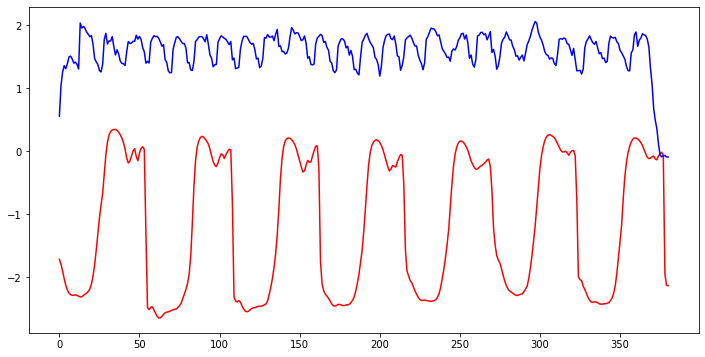

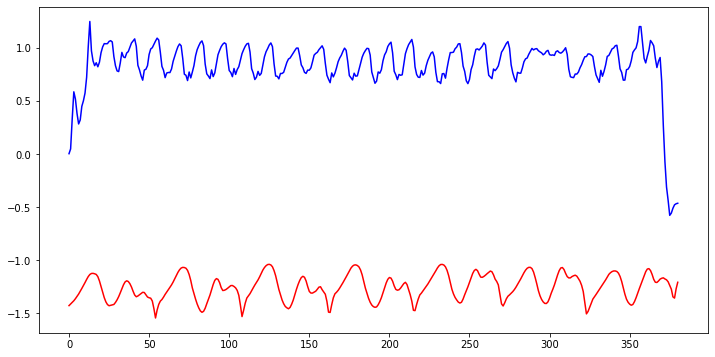

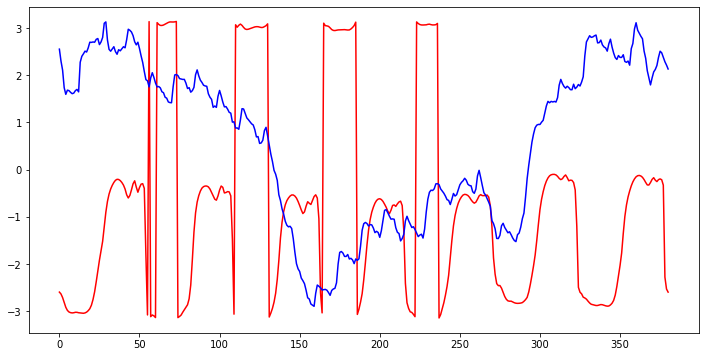

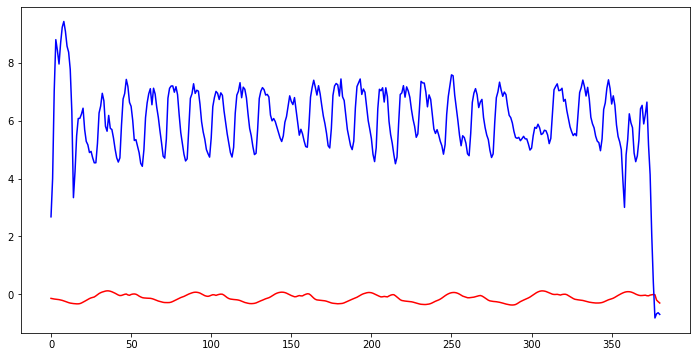

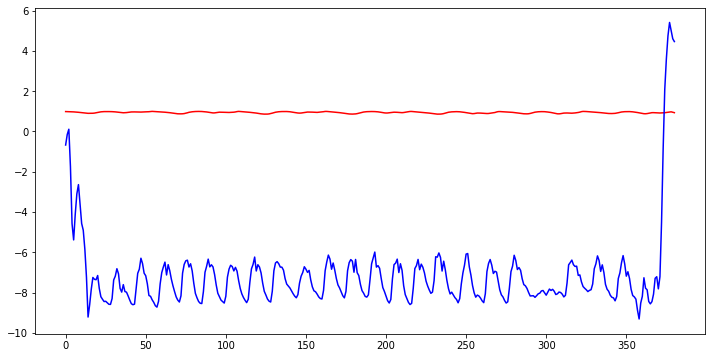

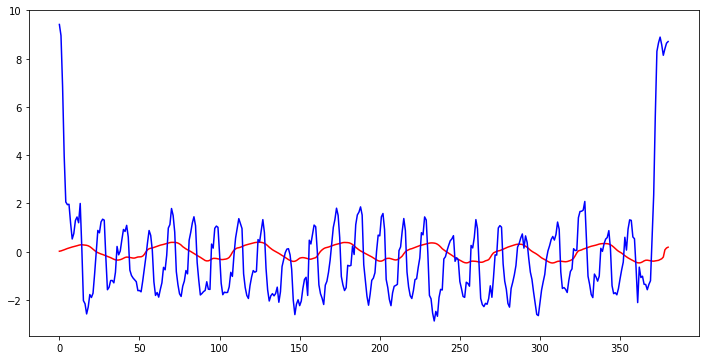

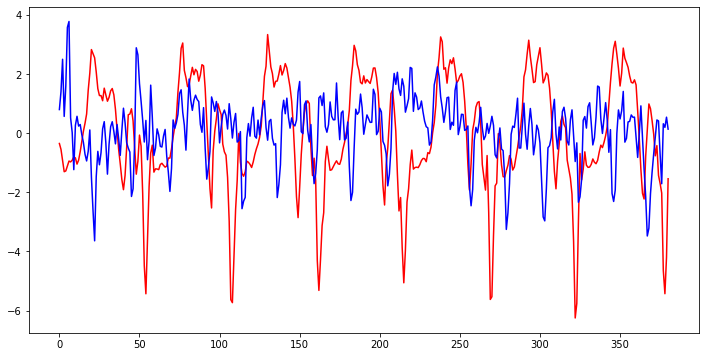

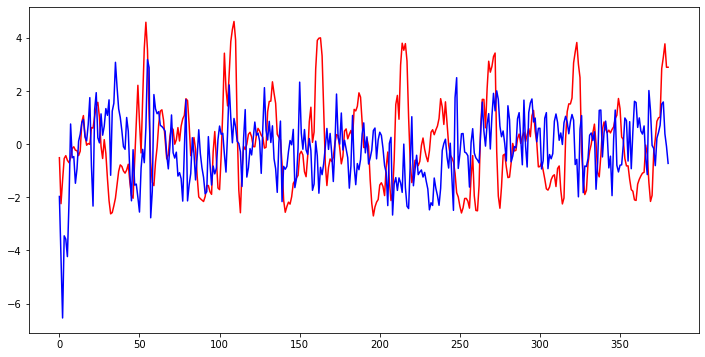

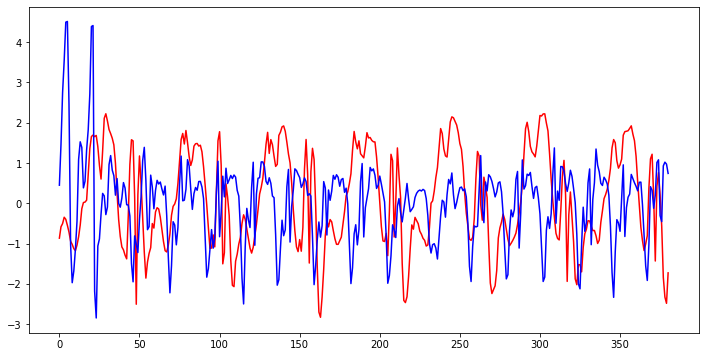

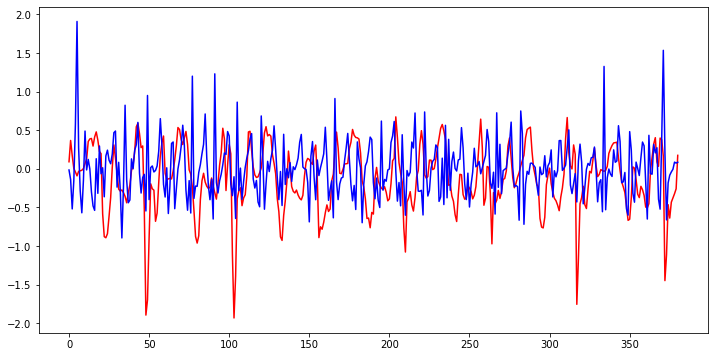

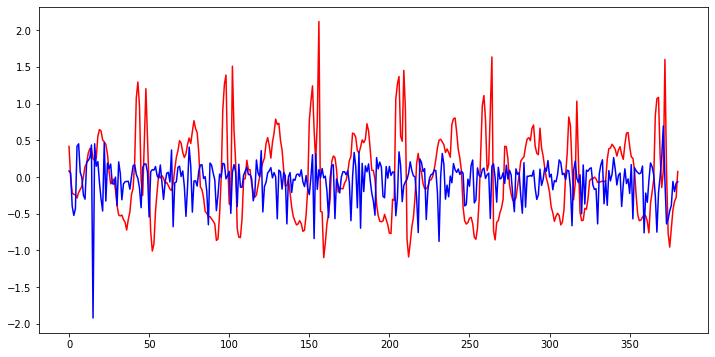

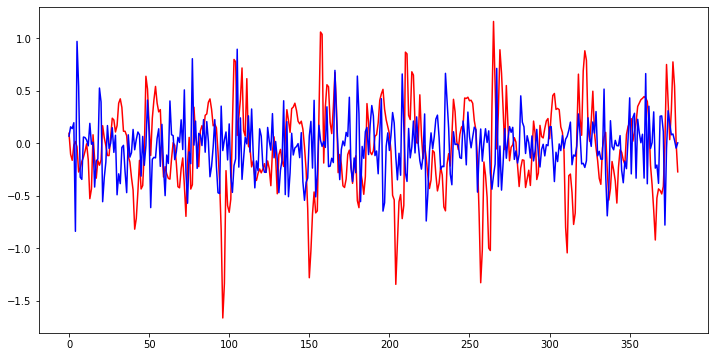

In [18]:
for idx in range(X_train.shape[1]):
    plt.figure(figsize=[12,6])
    plt.plot(walking_data[0:real_data.shape[0], idx], color='r')
    plt.plot(real_data[:, idx], color='b')

In [19]:
# we get 12% accuracy for sitting. Trains set roll pitch yaw is near zero whereas ours is like of amplitude 2
# but we get 1% on walking
# improvements
# 1. make sure mapping from ios to android is correct
# 2. cut the bounadaries of raw data to remove the data when i press start and stop
# 3. test dataset 1 which is drawn from android